# Pneumonia Detection with Chest X-ray Images

## Setup

### Import libraries

In [1]:
import copy
from itertools import islice
import os
from PIL import Image
import random
import sys
from typing import Tuple

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import models, transforms
from torchvision.datasets import ImageFolder

%matplotlib inline

### Using GPU for training if available

In [2]:
print(f'Python version: {sys.version_info.major}.{sys.version_info.minor}')
print(f'PyTorch version: {torch.__version__}')
print(f'Torchvision version: {torchvision.__version__}')

def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    elif torch.backends.mps.is_built():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')
        
    return device


device = get_device()
print(f'Using device: {device}')

Python version: 3.11
PyTorch version: 2.0.1
Torchvision version: 0.15.2
Using device: mps


## Exploring the dataset

### Find smallest image size

In [3]:
ROOT_FOLDER = 'dataset/'
TRAINING_FOLDER = f'{ROOT_FOLDER}train/'
VALIDATION_FOLDER = f'{ROOT_FOLDER}val/'
TEST_FOLDER = f'{ROOT_FOLDER}test/'

In [4]:
def find_smallest_image(dataset_root: str) -> Tuple[str, Tuple[int, int]]:
    smallest_width = smallest_height = None
    smallest_filename = ''
    
    for root, _, filenames in os.walk(dataset_root):
        for filename in filenames:
            if filename.endswith(('.jpg', '.png', '.jpeg')):
                path = os.path.join(root, filename)
                with Image.open(path) as image:
                    width, height = image.size
                    if (
                        smallest_width is None
                        or smallest_height is None
                        or width * height < smallest_width * smallest_height
                    ):
                        smallest_width, smallest_height = (width, height)
                        smallest_filename = filename

    return smallest_filename, (smallest_width, smallest_height)


_, smallest_size_training = find_smallest_image(TRAINING_FOLDER)
_, smallest_size_validation = find_smallest_image(VALIDATION_FOLDER)
_, smallest_size_test = find_smallest_image(TEST_FOLDER)
smallest_width, smallest_height = min(
    smallest_size_training, smallest_size_validation, smallest_size_test
)
print(f'{smallest_width}x{smallest_height}')

384x127


### Loading and transforming the files

In [5]:
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
torch.random.manual_seed(RANDOM_SEED);

In [6]:
IMAGE_SIZE = 400
ROTATION_DEGREE = 20

In [7]:
resize = transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE))
to_tensor = transforms.ToTensor()

shared_transforms = [resize, to_tensor]

training_transforms = transforms.Compose([
    resize,
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=ROTATION_DEGREE),
    to_tensor
])

In [8]:
# Dataset root URL
# https://ltu.app.box.com/s/ywboito9frcx5w4c4mzrrrl4qf2rh9u3/'

training_dataset = ImageFolder(
    root=TRAINING_FOLDER, transform=training_transforms
)
validation_dataset = ImageFolder(
    root=VALIDATION_FOLDER, transform=transforms.Compose(shared_transforms))
test_dataset = ImageFolder(
    root=TEST_FOLDER, transform=transforms.Compose(shared_transforms))

In [9]:
print(len(training_dataset))
print(len(validation_dataset))
len(test_dataset)

5216
16


624

In [10]:
BATCH_SIZE = 50

In [11]:
training_loader = DataLoader(
    training_dataset, batch_size=BATCH_SIZE, shuffle=True
)
validation_loader = DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, shuffle=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

In [12]:
classes = test_dataset.classes

In [13]:
%%script false --no-raise-error 

class_id = 0
while class_id < len(classes):
    for images, labels in training_loader:
        for image, label in zip(images, labels):
            if class_id == label:
                plt.figure(figsize=(8, 4))
                plt.title(f'Class: {classes[class_id]}')
                plt.imshow(image.permute(1, 2, 0))
                plt.show()
                
                class_id += 1

## Training models

### Logging

In [14]:
writer = SummaryWriter()

In [15]:
def train_model(
    model, criterion, optimizer, training_loader, validation_loader, num_epochs
):
    def train(epoch_loss):
        model.train()
        for _, (images, labels) in enumerate(training_loader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            training_prediction = model(images)
            training_loss = criterion(training_prediction, labels)
            training_loss.backward()
            
            optimizer.step()

            epoch_loss += training_loss.item() * len(labels)
        
        epoch_loss /= len(training_loader)
        writer.add_scalar(f'Loss/train:', epoch_loss, epoch)
        print(
            f'\r[Training] Epoch [{epoch + 1} / {num_epochs}], '
            f'Epoch Loss: {epoch_loss:.6f}'
        )
        
    def validate():
        model.eval()
        
        with torch.no_grad():
            validation_loss = 0

            for _, (images, labels) in enumerate(validation_loader):
                images = images.to(device)
                labels = labels.to(device)
                validation_prediction = model(images)
                validation_loss += criterion(
                    validation_prediction, labels
                ).item() * len(labels)

            validation_loss /= len(validation_loader)
            writer.add_scalar(f'Loss/train:', validation_loss, epoch)
            print(
                f'\r[Validation] Epoch [{epoch + 1} / {num_epochs}], '
                f'Validation Loss: {validation_loss:.6f}'
            )
    
        return validation_loss
    
    best_validation_loss = None

    model = model.to(device)
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        train(epoch_loss)
        validation_loss = validate()

        if best_validation_loss is None or validation_loss < best_validation_loss:
            best_model_state = copy.deepcopy(model.state_dict())
            print('\t Better model found')
    
            best_validation_loss = validation_loss

    writer.flush()
    return best_model_state

In [16]:
def test_model(model, criterion, test_loader):
    num_correct = 0
    num_total = 0
    test_loss = 0
    true_labels = []
    predicted_labels = []
    
    model = model.to(device)

    model.eval()
    with torch.no_grad():
        for _, (images, labels) in enumerate(test_loader):
            labels = labels.to(device)
            num_total += labels.size(0)
            true_labels.extend(labels.tolist())
            
            images = images.to(device)
            prediction = model(images)
            predicted_batch_labels = torch.argmax(prediction, dim=1)
            num_correct += (predicted_batch_labels == labels).sum().item()
            predicted_labels.extend(predicted_batch_labels.tolist())
            
            test_loss += criterion(prediction, labels).item() * len(labels)

    accuracy = num_correct / num_total
    test_loss /= num_total

    print(
        f'\nAccuracy score: {accuracy:.1%} '
        f'({num_correct} correct out of {num_total})')
    
    print(f'Test loss: {test_loss:.4f}')

    return (
        accuracy, 
        test_loss, 
        true_labels, 
        predicted_labels,
    )

### Hyperparameters

In [25]:
NUM_EPOCHS = 10
LEARNING_RATE = 3e-5
WEIGHT_DECAY = 1e-2

### Models

In [18]:
resnet18_model = models.resnet18(weights='DEFAULT')
resnet34_model = models.resnet34(weights='DEFAULT')
alexnet = models.alexnet(weights='DEFAULT')

models_to_fine_tune = {
    'ResNet-18': resnet18_model,
    # 'ResNet-34': resnet34_model,
    # 'AlexNet': alexnet,
}

In [19]:
NUM_MODELS_TO_SKIP = 0

In [20]:
models_to_train = dict(
    islice(models_to_fine_tune.items(), NUM_MODELS_TO_SKIP, None)
)
list(models_to_train.keys())

['ResNet-18']

In [26]:
num_classes = len(classes)


for model_name, model in models_to_train.items():
    if model_name.startswith('ResNet'):
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'AlexNet':
        model.classifier[6] = nn.Linear(
            model.classifier[6].in_features, num_classes
        )
    
    try:
        best_model_filename = f'best-model-{model_name}.pth'
        best_model_state = torch.load(best_model_filename)
        torch.load(best_model_state, f'best-model-{model_name}.pth')
        model.load_state_dict(best_model_state)
    except Exception:
        pass
    
    optimizer_for_fine_tuning = torch.optim.Adam(
        model.parameters(), 
        lr=LEARNING_RATE, 
        weight_decay=WEIGHT_DECAY,
    )
    print(f'Training {model_name}: \n')
    
    best_fine_tuned_model_state = train_model(
        model, 
        nn.CrossEntropyLoss(), 
        optimizer_for_fine_tuning, 
        training_loader, 
        validation_loader, 
        NUM_EPOCHS,
    )
    torch.save(best_fine_tuned_model_state, f'best-model-{model_name}.pth')

Training ResNet-18: 

[Training] Epoch [1 / 10], Epoch Loss: 5.942327
[Validation] Epoch [1 / 10], Validation Loss: 6.321256
	 Better model found
[Training] Epoch [2 / 10], Epoch Loss: 3.392039
[Validation] Epoch [2 / 10], Validation Loss: 11.478539
[Training] Epoch [3 / 10], Epoch Loss: 2.941870
[Validation] Epoch [3 / 10], Validation Loss: 15.074228
[Training] Epoch [4 / 10], Epoch Loss: 2.109446
[Validation] Epoch [4 / 10], Validation Loss: 3.302673
	 Better model found
[Training] Epoch [5 / 10], Epoch Loss: 2.123794
[Validation] Epoch [5 / 10], Validation Loss: 9.808234
[Training] Epoch [6 / 10], Epoch Loss: 1.651622
[Validation] Epoch [6 / 10], Validation Loss: 8.380690
[Training] Epoch [7 / 10], Epoch Loss: 1.535221
[Validation] Epoch [7 / 10], Validation Loss: 1.546458
	 Better model found
[Training] Epoch [8 / 10], Epoch Loss: 1.520906
[Validation] Epoch [8 / 10], Validation Loss: 0.873854
	 Better model found
[Training] Epoch [9 / 10], Epoch Loss: 1.255011
[Validation] Epoch [

## Evaluating the models

### Loading the best models

In [27]:
criterion_ft = nn.CrossEntropyLoss()

best_models = {}
for model_name, model in models_to_fine_tune.items():
    try:
        best_model_filename = f'best-model-{model_name}.pth'
        best_model_state = torch.load(best_model_filename)
        if model_name.startswith('ResNet'):
            model.fc = nn.Linear(model.fc.in_features, num_classes)
        elif model_name == 'AlexNet':
            model.classifier[6] = nn.Linear(
                model.classifier[6].in_features, num_classes
            )
        
        model.load_state_dict(best_model_state)
    except Exception as e:
        print(f'Could not load model {model_name}: {e}')
    
    best_models[model_name] = model

list(best_models.keys())

['ResNet-18']

### Evaluating performance

In [28]:
def plot_confusion_matrix_heatmap(
    confusion_matrix: pd.DataFrame, model_name: str
):
    heatmap = sns.heatmap(confusion_matrix_dataframe, annot=True)
    plt.ylabel('True label', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted label', fontsize=14, fontweight='bold')
    plt.title(f'Confusion matrix for {model_name}')
    plt.show()

    
def plot_mislabeled_images(
    test_loader, y_predicted, y_true, classes=classes
):
    for (images, labels) in test_loader:
        for i, (predicted_label, true_label, image, label) in enumerate(
            zip(y_predicted, y_true, images, labels)
        ):
            if predicted_label != true_label:
                plt.figure(figsize=(8, 4))
                plt.title(
                    f'#{i} Predicted Label: "{classes[predicted_label]}" '
                    f'True Label: "{classes[true_label]}" '
                )
                plt.imshow(image.permute(1, 2, 0))
                plt.show()


Evaluating model ResNet-18:

Accuracy score: 85.1% (531 correct out of 624)
Test loss: 0.4799


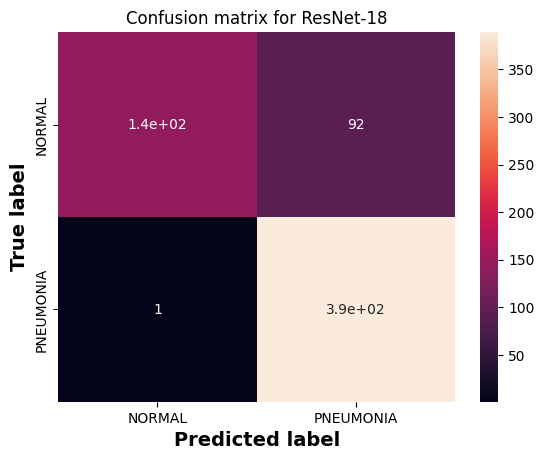

In [29]:
test_loader = DataLoader(
    test_dataset, batch_size=50, shuffle=True
)


for model_name, model in best_models.items():
    print(f'\nEvaluating model {model_name}:')
    
    _, _, y_true, y_predicted = test_model(
        model, criterion_ft, test_loader
    )
    confusion_matrix_ = confusion_matrix(y_true, y_predicted)
    confusion_matrix_dataframe = pd.DataFrame(
        confusion_matrix_, 
        index=classes,
        columns=classes,
    )

    plot_confusion_matrix_heatmap(
        confusion_matrix_dataframe, model_name
    )
    
    # plot_mislabeled_images(
    #     test_loader, y_predicted, y_true, classes
    # )

In [39]:
from sklearn import metrics


recall = metrics.recall_score(y_true, y_predicted)
print(f'The recall of the positive class is {recall:.4f}')

precision = metrics.precision_score(y_true, y_predicted)
print(f'The precision of the positive class is {precision:.4f}')

specificity = metrics.recall_score(y_true, y_predicted, pos_label=0)
print(f'The specificity is {specificity:.4f}')

f1_score = metrics.f1_score(y_true, y_predicted)
print(f'The F1-score is {f1_score:.4f}')

The recall of the positive class is 0.9974
The precision of the positive class is 0.8087
The specificity is 0.6068
The F1-score is 0.8932


In [41]:
print(metrics.classification_report(y_true, y_predicted))

              precision    recall  f1-score   support

           0       0.99      0.61      0.75       234
           1       0.81      1.00      0.89       390

    accuracy                           0.85       624
   macro avg       0.90      0.80      0.82       624
weighted avg       0.88      0.85      0.84       624



The accuracy of the model is 85%, even the macro-average is 82% which is acceptable.

The recall value is near 100% which means almost all the positive cases are currently identified by our model.

The precision value is closer to 80% which means about every fifth positive prediction is a false positive.

The bottleneck is the amount of false positives as we can see from the specificity value which is only 61%, meaning that 2 out of 5 healthy lungs get erroneously labeled as affected by pneumonia.

The model is skewed towards providing false positives which means it can be useful as an assisted model where the positive samples are classified by human experts.

### Change of loss function over epochs

Since the labels in the Tensorboard logging were incorrectly setup, both the training and the validation losses got logged as training losses.

Here are the separated results and the resulting plots about the evolution of the loss function over the 3+10 epochs of training.

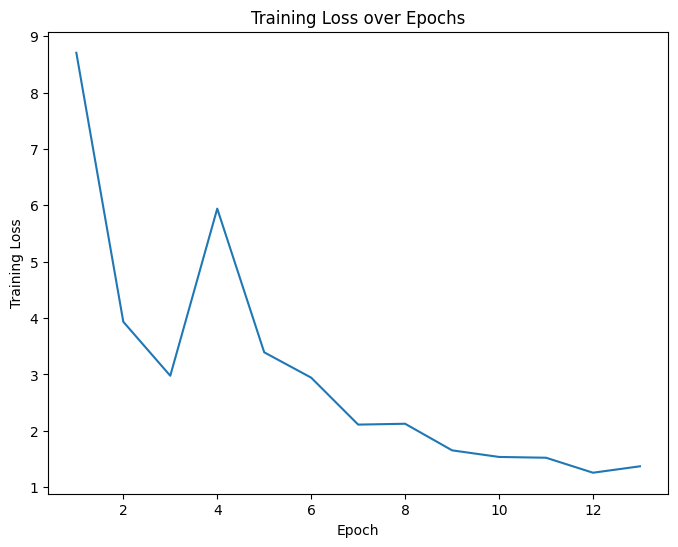

In [42]:
training_losses = [
    8.709,
    3.934,
    2.976,
    5.942,
    3.392,
    2.942,
    2.109,
    2.124,
    1.652,
    1.535,
    1.521,
    1.255,
    1.369,
    
]
validation_losses = [
    7.315,
    7.907,
    14.15,
    6.321,
    11.47,
    15.07,
    3.302,
    9.808,
    8.380,
    1.546,
    0.873,
    0.990,
    4.65,
]

TOTAL_NUMBER_OF_EPOCHS = len(training_losses) + 1
START_INDEX = 1
plt.figure(figsize=(8, 6))
plt.plot(
    range(START_INDEX, TOTAL_NUMBER_OF_EPOCHS + START_INDEX), 
    training_losses
)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')

plt.plot(
    range(START_INDEX, TOTAL_NUMBER_OF_EPOCHS + START_INDEX), 
    validate_accuracy_values)
plt.ylabel('Validation loss')
plt.title('Validation Accuracy over Epochs')
plt.show()